# Preprocessing

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
import text_processing

In [2]:
# wczytanie labeli jako df
labels_path = 'JRC/jrc-acquis-eurovoc-descriptors.txt'

labels_df = pd.read_csv(labels_path, sep='\t\t',engine='python', header=None)
labels_df.rename(columns={0: 'name', 1: 'labels'}, inplace=True)
labels_df['labels'] = labels_df['labels'].apply(lambda string: list(map(int, string.split())))
labels_df.head()

,name,labels
0,21996A0127(02),"[5254, 1558, 2718, 336, 3468, 1871]"
1,21996A0520(01),"[753, 5404, 3454, 888, 614, 4631]"
2,21996A0706(01),"[11, 1804, 5765, 3461, 2602]"
3,21996A0706(02),"[11, 1633, 5765, 3461, 2602]"
4,21996A0716(01),"[216, 4829, 1159, 5420, 134]"


In [3]:
# wczytanie dokumentów
data_folder = 'JRC'
text_dict = {}

for year in os.listdir(data_folder):
    year_path = os.path.join(data_folder,year)
    if os.path.isdir(year_path):
        for file_name in os.listdir(year_path):
            file_path = os.path.join(year_path, file_name)
            tree = ET.parse(file_path)
            root = tree.getroot()

            text = ''
            for elem in root.iter('p'):
                text += elem.text + ' '
            
            if len(text) < 100_000:
                text_dict[root.attrib['n']] = text

text_df = pd.DataFrame.from_dict(text_dict, orient='index')
text_df.reset_index(inplace=True)
text_df.rename(columns={'index': 'name', 0: 'text'}, inplace=True)
text_df.head()

,name,text
0,31988D0124,Decyzja Komisji z dnia 21 stycznia 1988 r. ust...
1,31988L0301,Dyrektywa Komisji z dnia 16 maja 1988 r. w spr...
2,31988D0381,Decyzja Rady z dnia 24 czerwca 1988 r. dotyczą...
3,31988L0409,Dyrektywa Rady z dnia 15 czerwca 1988 r. ustan...
4,31988R0442,Rozporządzenie Komisji (EWG) NR 442/88 z dnia ...


In [4]:
# połączenie 
final_df = pd.merge(text_df, labels_df, how='inner', on='name')
final_df.head()

,name,text,labels
0,51994EC1868,[pic] | KOMISJA WSPÓLNOT EUROPEJSKICH | Brukse...,"[2548, 5096, 2194, 1654, 5498, 2681, 2974]"
1,31995L0013,Dyrektywa Komisji 95/13/WE z dnia 23 maja 1995...,"[893, 1425, 3861, 5235, 3648, 142]"
2,31995R3069,Rozporządzenie Rady (WE) nr 3069/95 z dnia 21 ...,"[5229, 4829, 2891, 133, 2026, 4790]"
3,31995R2694,Rozporządzenie Komisji (WE) nr 2694/95 z dnia ...,"[5751, 4381, 4170, 3156]"
4,31995D0467,Decyzja Komisji z dnia 24 października 1995 r....,"[3879, 1826, 3134, 179, 4036, 3645]"


In [6]:
test = text_processing.preprocess_text(final_df['text'], polish_letters=True, lowercase=True, special_characters=True, stopwords=True, lemmatization=True)

In [8]:
final_df['processed_text'] = test
final_df.to_csv('processed_data.csv', index=False)
print(f"Ostateczna wielkość zbioru danych to {len(final_df)}")
final_df.head()

,name,text,labels,processed_text
0,51994EC1868,[pic] | KOMISJA WSPÓLNOT EUROPEJSKICH | Brukse...,"[2548, 5096, 2194, 1654, 5498, 2681, 2974]",pica komisja wspolnot europejski bruksela kom ...
1,31995L0013,Dyrektywa Komisji 95/13/WE z dnia 23 maja 1995...,"[893, 1425, 3861, 5235, 3648, 142]",dyrektywa komisja dzień maj r wykonujaca dyrek...
2,31995R3069,Rozporządzenie Rady (WE) nr 3069/95 z dnia 21 ...,"[5229, 4829, 2891, 133, 2026, 4790]",rozporzadzenie rada nr dzień grudzień r ustana...
3,31995R2694,Rozporządzenie Komisji (WE) nr 2694/95 z dnia ...,"[5751, 4381, 4170, 3156]",rozporzadzenie komisja nr dzień listopad r dot...
4,31995D0467,Decyzja Komisji z dnia 24 października 1995 r....,"[3879, 1826, 3134, 179, 4036, 3645]",decyzja komisja dzień pazdziernika r wykonujac...


# Train/Test split

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utilities import read_data
from dataset_preparation import prepare_dataset

In [2]:
# most_common_full = ['1309', '3568', '4038', '20', '2771', '889', '616', '69', '183', '2300']

labels_2 = [1309, 3568]
labels_5 = [1309, 3568, 4038, 889, 616]
labels_8 = [1309, 3568, 4038, 20, 2771, 889, 616, 183]

file_path = 'processed_data.csv'
df = read_data(file_path)
df.head()

,processed_text,labels
0,pica komisja wspolnot europejski bruksela kom ...,"[2548, 5096, 2194, 1654, 5498, 2681, 2974]"
1,dyrektywa komisja dzień maj r wykonujaca dyrek...,"[893, 1425, 3861, 5235, 3648, 142]"
2,rozporzadzenie rada nr dzień grudzień r ustana...,"[5229, 4829, 2891, 133, 2026, 4790]"
3,rozporzadzenie komisja nr dzień listopad r dot...,"[5751, 4381, 4170, 3156]"
4,decyzja komisja dzień pazdziernika r wykonujac...,"[3879, 1826, 3134, 179, 4036, 3645]"


In [6]:
df_2 = prepare_dataset(df, set(labels_2), reduce_size=True)
df_5 = prepare_dataset(df, set(labels_5))
df_8 = prepare_dataset(df, set(labels_8))

df_2.head()

1309
0.8657056145675266
1309
0.8447565414463293
4038
0.884811102544333


,processed_text,correct_labels
5,rozporzadzenie komisja nr dzień pazdziernika r...,3568
6,decyzja komisja dzień czerwiec r zmieniajaca d...,1309
10,decyzja komisja dzień lipiec r ustanawiajaca s...,1309
11,decyzja przedstawiciel rzadow panstw czlonkows...,0
13,decyzja rada dzień czerwiec r sprawa warunkow ...,1309


In [7]:
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(df_2['processed_text'], df_2['correct_labels'], test_size=0.2, random_state=1)
x_5_train, x_5_test, y_5_train, y_5_test = train_test_split(df_5['processed_text'], df_5['correct_labels'], test_size=0.2, random_state=1)
x_8_train, x_8_test, y_8_train, y_8_test = train_test_split(df_8['processed_text'], df_8['correct_labels'], test_size=0.2, random_state=1)

In [8]:
from collections import Counter
trd = dict(Counter(y_2_train))
tsd = dict(Counter(y_2_test))
(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],
             columns=['Target Label', 'Train Count', 'Test Count'])
.sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
1,0,1852,449
2,1309,1213,321
0,3568,1007,248


# Feature extraction

 Jak się okazuje nie jest to konieczne, poniewaz robi się to grid searchem 

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)

tv_2_train_features = tv.fit_transform(x_2_train)
tv_2_test_features = tv.fit_transform(x_2_test)
print(f"Dla 2 klas dokumentów: \n\
    Rozmiar cech treningowych = {tv_2_train_features.shape}\n\
    Rozmiar cech testowych = {tv_2_test_features.shape}\n")

tv_5_train_features = tv.fit_transform(x_5_train)
tv_5_test_features = tv.fit_transform(x_5_test)
print(f"Dla 5 klas dokumentów: \n\
    Rozmiar cech treningowych = {tv_5_train_features.shape}\n\
    Rozmiar cech testowych = {tv_5_test_features.shape}\n")

tv_8_train_features = tv.fit_transform(x_8_train)
tv_8_test_features = tv.fit_transform(x_8_test)
print(f"Dla 8 klas dokumentów: \n\
    Rozmiar cech treningowych = {tv_8_train_features.shape}\n\
    Rozmiar cech testowych = {tv_8_test_features.shape}\n")


Dla 2 klas dokumentów: 
    Rozmiar cech treningowych = (15938, 249421)
    Rozmiar cech testowych = (3985, 116995)

Dla 5 klas dokumentów: 
    Rozmiar cech treningowych = (15700, 238949)
    Rozmiar cech testowych = (3926, 114275)

Dla 8 klas dokumentów: 
    Rozmiar cech treningowych = (14680, 228202)
    Rozmiar cech testowych = (3670, 119357)



# Szkolenie modeli 

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(x_2_train, y_2_train)

In [25]:
gs_lr.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=10, random_state=42))])

In [27]:
best_lr_test_score = gs_lr.score(x_2_test, y_2_test)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.9545796737766625


In [39]:
import book as meu
mnb_predictions = gs_lr.predict(x_2_test)
unique_classes = list(set(y_2_test))
meu.get_metrics(true_labels=y_2_test, predicted_labels=mnb_predictions)

Accuracy: 0.9546
Precision: 0.9527
Recall: 0.9546
F1 Score: 0.9531


In [31]:
meu.display_classification_report(true_labels=y_2_test, predicted_labels=mnb_predictions, classes=unique_classes)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3422
        3568       0.96      0.92      0.94       228
        1309       0.82      0.70      0.75       335

    accuracy                           0.95      3985
   macro avg       0.91      0.87      0.89      3985
weighted avg       0.95      0.95      0.95      3985



In [43]:
meu.display_confusion_matrix_pretty(true_labels=y_2_test, predicted_labels=mnb_predictions, classes=unique_classes)

Predicted:          
                   0    3568 1309
Actual: 0          3361    9   52
        3568         18  210    0
        1309        102    0  233

## Logistic Regression v2

### 2 Classes

In [ ]:
lr_pipeline_t = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))])

param_grid_t = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr_t = GridSearchCV(lr_pipeline_t, param_grid_t, cv=5, verbose=2)
gs_lr_t = gs_lr.fit(xt_2_train, yt_2_train)

In [58]:
gs_lr_t.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=5, random_state=42))])

In [59]:
best_lr_test_score_t = gs_lr_t.score(xt_2_test, yt_2_test)
print('Test Accuracy :', best_lr_test_score_t)

Test Accuracy : 0.9410609037328095


In [60]:
import book as meu
mnb_predictions_t = gs_lr_t.predict(xt_2_test)
unique_classes_t = list(set(yt_2_test))
meu.get_metrics(true_labels=yt_2_test, predicted_labels=mnb_predictions_t)

Accuracy: 0.9411
Precision: 0.941
Recall: 0.9411
F1 Score: 0.941


In [61]:
meu.display_classification_report(true_labels=yt_2_test, predicted_labels=mnb_predictions_t, classes=unique_classes_t)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       478
        3568       0.97      0.98      0.98       222
        1309       0.91      0.91      0.91       318

    accuracy                           0.94      1018
   macro avg       0.94      0.95      0.94      1018
weighted avg       0.94      0.94      0.94      1018



In [62]:

meu.display_confusion_matrix_pretty(true_labels=yt_2_test, predicted_labels=mnb_predictions_t, classes=unique_classes_t)

Predicted:          
                   0    3568 1309
Actual: 0           450    2   26
        3568          3  218    1
        1309         24    4  290

### 5 classes

In [ ]:
lr_pipeline_t = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))])

param_grid_t = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr_t = GridSearchCV(lr_pipeline_t, param_grid_t, cv=5, verbose=2)
gs_lr_t = gs_lr_t.fit(x_5_train, y_5_train)

In [21]:
gs_lr_t.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=10, random_state=42))])

In [22]:
best_lr_test_score_t = gs_lr_t.score(x_5_test, y_5_test)
print('Test Accuracy :', best_lr_test_score_t)

Test Accuracy : 0.8894952251023193


In [23]:
import book as meu
mnb_predictions_t = gs_lr_t.predict(x_5_test)
unique_classes_t = list(set(y_5_test))
meu.get_metrics(true_labels=y_5_test, predicted_labels=mnb_predictions_t)

Accuracy: 0.8895
Precision: 0.8913
Recall: 0.8895
F1 Score: 0.8888


In [24]:

meu.display_confusion_matrix_pretty(true_labels=y_5_test, predicted_labels=mnb_predictions_t, classes=unique_classes_t)

Predicted:                         
                   0    4038 616  3568 889  1309
Actual: 0           390    9   15    5    1   24
        4038         18  183    3    0    0    1
        616          45    0   82    0    0    2
        3568          4    0    0  254    0    1
        889           6    1    0    0  124    0
        1309         24    0    2    1    0  271

### 8 classes

In [ ]:
lr_pipeline_t = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))])

param_grid_t = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr_t = GridSearchCV(lr_pipeline_t, param_grid_t, cv=5, verbose=2)
gs_lr_t = gs_lr_t.fit(x_8_train, y_8_train)

In [27]:
best_lr_test_score_t = gs_lr_t.score(x_8_test, y_8_test)
print('Test Accuracy :', best_lr_test_score_t)

Test Accuracy : 0.8647272727272727


In [28]:
import book as meu
mnb_predictions_t = gs_lr_t.predict(x_8_test)
unique_classes_t = list(set(y_8_test))
meu.get_metrics(true_labels=y_8_test, predicted_labels=mnb_predictions_t)

Accuracy: 0.8647
Precision: 0.8673
Recall: 0.8647
F1 Score: 0.8638


In [29]:

meu.display_confusion_matrix_pretty(true_labels=y_8_test, predicted_labels=mnb_predictions_t, classes=unique_classes_t)

Predicted:                                        
                   0    4038 616  3568 2771 20   183  889  1309
Actual: 0           261   11   14    2   10    0    1    0   13
        4038         15  162    0    0    0    0    0    0    1
        616          37    0   47    0    0    0    0    0    0
        3568          5    0    0  158    0    1    0    0    0
        2771         11    0    1    1   57    1    0    0   23
        20            6    0    1    0    0  115    0    0    0
        183           2    1    0    0    0    0  119    1    0
        889           7    0    0    0    0    0    0  114    0
        1309          9    0    1    0   10    1    0    0  156

## SVM

### 2 classes

In [33]:
from sklearn.svm import LinearSVC

In [ ]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(xt_2_train, yt_2_train)

In [79]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=5, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=5, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 5,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

In [81]:
best_svm_test_score = gs_svm.score(xt_2_test, yt_2_test)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.9518664047151277


In [82]:
import book as meu
svm_predictions_t = gs_svm.predict(xt_2_test)
unique_classes_t = list(set(yt_2_test))
meu.get_metrics(true_labels=yt_2_test, predicted_labels=svm_predictions_t)

Accuracy: 0.9519
Precision: 0.9518
Recall: 0.9519
F1 Score: 0.9518


In [83]:
meu.display_classification_report(true_labels=yt_2_test, predicted_labels=svm_predictions_t, classes=unique_classes_t)

              precision    recall  f1-score   support

        3568       0.98      0.99      0.99       258
           0       0.94      0.95      0.95       458
        1309       0.94      0.92      0.93       302

    accuracy                           0.95      1018
   macro avg       0.95      0.95      0.95      1018
weighted avg       0.95      0.95      0.95      1018



In [84]:

meu.display_confusion_matrix_pretty(true_labels=yt_2_test, predicted_labels=svm_predictions_t, classes=unique_classes_t)

Predicted:          
                   3568 0    1309
Actual: 3568        255    3    0
        0             3  436   19
        1309          1   23  278

### 5 classes

In [36]:
from train_models import search_parameters

In [ ]:
best_svm = search_parameters(model=LinearSVC(random_state=42),
                                          model_params={'C': [0.01, 0.1, 1, 5]},
                                          data=(x_5_train, y_5_train))

In [40]:
best_svm.score(x_5_test, y_5_test)

0.8915416098226466

### 8 classes

In [42]:
best_svm = search_parameters(model=LinearSVC(random_state=42),
                                          model_params={'C': [0.01, 0.1, 1, 5]},
                                          data=(x_8_train, y_8_train),
                                          verbose=1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [59]:
best_svm.score(x_8_test, y_8_test)

0.8785454545454545

In [68]:
y_pred = best_svm.predict(x_8_test)

In [71]:
import evaluate_models
evaluate_models.calculate_metrics(y_8_test, y_pred)

Metryki dla :
        accuracy = 0.88
        f1 = 0.88
        precission = 0.88
        recall = 0.88


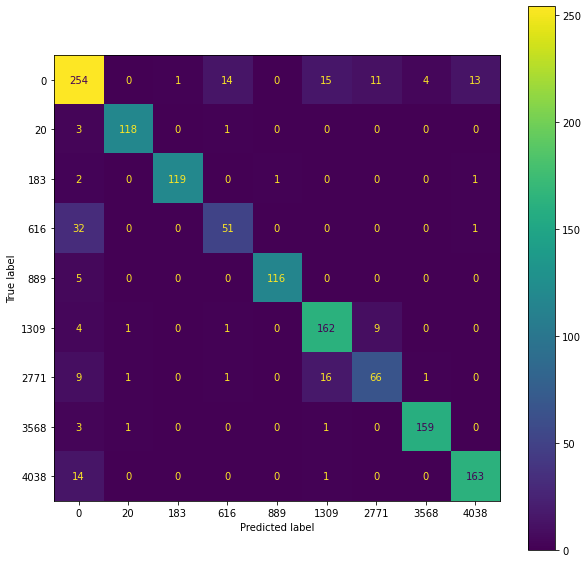

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
m = confusion_matrix(y_8_test, y_pred, labels=best_svm.classes_)
c = ConfusionMatrixDisplay.from_predictions(y_8_test, y_pred, labels=best_svm.classes_)
c.figure_.set_size_inches(10, 10)
plt.show()


## Random Forest

### 2 classes

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', RandomForestClassifier(random_state=42))])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__n_estimators': [50, 75, 100, 125, 150]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(x_2_train, y_2_train)

In [15]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()),
  ('svm', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'svm': RandomForestClassifier(random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__bootstrap': True,
 'svm__ccp_alpha': 0.0,
 'svm__class_weight': None,
 'svm__criterion': 'gini',
 'svm__max_depth': None,
 'svm__max_features': 'auto',
 'svm__max_leaf_nodes': None,

In [16]:
best_svm_test_score = gs_svm.score(x_2_test, y_2_test)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.9263261296660118


### 5 classes

In [89]:
best_rf = search_parameters(model=RandomForestClassifier(random_state=42),
                                          model_params={'n_estimators': [50, 75, 100, 125, 150]},
                                          data=(x_5_train, y_5_train),
                                          verbose=0)

In [90]:
best_rf.score(x_5_test, y_5_test)

0.8342428376534788

### 8 classes

In [91]:
best_rf = search_parameters(model=RandomForestClassifier(random_state=42),
                                          model_params={'n_estimators': [50, 75, 100, 125, 150]},
                                          data=(x_8_train, y_8_train),
                                          verbose=0)

In [92]:
best_rf.score(x_8_test, y_8_test)

0.8014545454545454

# DO USUNIĘCIA 


## Po prostu ile jest dokumentów w top 10 klasach

In [54]:
# https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
# zeby zamienic ten durny string na liste

import pprint
import numpy as np

new_df = df['labels'].copy()
new_df.head()

size_dct = {}
most_common_full = ['1309', '3568', '4038', '20', '2771', '889', '616', '69', '183', '2300']

for i in range (2, len(most_common_full)+1):
    most_common_set = set(most_common_full[:i])

    size_dct[i] = {}
    for elem in most_common_set:
        size_dct[i][elem] = 0
    
    for label in new_df:
        correct_label = label.strip('][').split(', ')

        intersection = most_common_set.intersection(correct_label)
        intersection_lst = list(intersection)

        if len(intersection_lst) >= 2:
            # remove this document from the dataframe
            pass
        if len(intersection_lst) == 1:
            size_dct[i][str(intersection_lst[0])] += 1
        
    
pprint.pprint(size_dct)


{2: {'1309': 1534, '3568': 1255},
 3: {'1309': 1519, '3568': 1254, '4038': 1159},
 4: {'1309': 1436, '20': 556, '3568': 846, '4038': 1133},
 5: {'1309': 909, '20': 549, '2771': 428, '3568': 845, '4038': 1130},
 6: {'1309': 909,
     '20': 549,
     '2771': 427,
     '3568': 836,
     '4038': 1052,
     '889': 758},
 7: {'1309': 899,
     '20': 549,
     '2771': 427,
     '3568': 827,
     '4038': 1007,
     '616': 655,
     '889': 632},
 8: {'1309': 898,
     '20': 549,
     '2771': 427,
     '3568': 827,
     '4038': 984,
     '616': 443,
     '69': 607,
     '889': 631},
 9: {'1309': 898,
     '183': 9,
     '20': 549,
     '2771': 427,
     '3568': 827,
     '4038': 983,
     '616': 443,
     '69': 8,
     '889': 631},
 10: {'1309': 681,
      '183': 9,
      '20': 545,
      '2300': 217,
      '2771': 365,
      '3568': 815,
      '4038': 981,
      '616': 429,
      '69': 8,
      '889': 631}}


## Top 8 dokumentów z top 10

In [103]:
# https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
# zeby zamienic ten durny string na liste

import pprint
import numpy as np

new_df = df['labels'].copy()
new_df.head()

size_dct = {}
most_common_full = ['1309', '3568', '4038', '20', '2771', '889', '616', '69', '183', '2300']

for i in range (len(most_common_full)):
    most_common_base = most_common_full[:]
    string_base = most_common_base[i] + ' i '
    del most_common_base[i]
    for j in range (len(most_common_base)):
        most_common_lst = most_common_base[:]
        string = string_base + most_common_lst[j]
        del most_common_lst[j]

        most_common_set = set(most_common_lst)
        
        size_dct[string] = {}

        for elem in most_common_set:
            size_dct[string][elem] = 0
    
        for label in new_df:
            correct_label = label.strip('][').split(', ')

            intersection = most_common_set.intersection(correct_label)
            intersection_lst = list(intersection)

        #     if len(intersection_lst) >= 2:
        #         # remove this document from the dataframe
        #         pass
            if len(intersection_lst) == 1:
                size_dct[string][str(intersection_lst[0])] += 1
        
    
# pprint.pprint(size_dct)


In [104]:
sorted_8_dct = {}
max_mean = 0

for deleted, val_dct in size_dct.items():
  sorted_8_dct[deleted] = min(val_dct.values())
sorted_8_dct = {k: v for k, v in sorted(sorted_8_dct.items(), key=lambda item: item[1], reverse=True)}

for key, value in sorted_8_dct.items():
  if value < 400:
    break
  values_dct = size_dct[key]
  values_lst = list(values_dct.values())
  std = np.std(values_lst)
  mean_ = np.mean(values_lst)
  
  if mean_ >= max_mean:
    print(f"{mean_} dla {key} przy std {std:.2f}")
    max_mean = mean_
  # print(f"Dla usuniętych wartości {key}:\n\
  # Odchylenie standardowe wynosi {std:.2f}\n\
  # Średnia wynosi {mean_}\n\n")

668.75 dla 1309 i 69 przy std 187.22
668.75 dla 69 i 1309 przy std 187.22
672.5 dla 69 i 2300 przy std 197.92
672.5 dla 2300 i 69 przy std 197.92


## Top 5 dokumentów z top 7

In [ ]:
# https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
# zeby zamienic ten durny string na liste

import pprint
import numpy as np

new_df = df['labels'].copy()
new_df.head()

size_dct = {}
most_common_full = ['1309', '3568', '4038', '20', '2771', '889', '616']

for i in range (len(most_common_full)):
    most_common_base = most_common_full[:]
    string_base = most_common_base[i] + ' i '
    del most_common_base[i]
    for j in range (len(most_common_base)):
        most_common_lst = most_common_base[:]
        string = string_base + most_common_lst[j]
        del most_common_lst[j]

        most_common_set = set(most_common_lst)
        
        size_dct[string] = {}

        for elem in most_common_set:
            size_dct[string][elem] = 0
    
        for label in new_df:
            correct_label = label.strip('][').split(', ')

            intersection = most_common_set.intersection(correct_label)
            intersection_lst = list(intersection)

        #     if len(intersection_lst) >= 2:
        #         # remove this document from the dataframe
        #         pass
            if len(intersection_lst) == 1:
                size_dct[string][str(intersection_lst[0])] += 1
        
    
pprint.pprint(size_dct)

In [102]:
sorted_5_dct = {}
max_mean = 0

for deleted, val_dct in size_dct.items():
  sorted_5_dct[deleted] = min(val_dct.values())
sorted_5_dct = {k: v for k, v in sorted(sorted_5_dct.items(), key=lambda item: item[1], reverse=True)}

for key, value in sorted_5_dct.items():
  if value < 600:
    break
  values_dct = size_dct[key]
  values_lst = list(values_dct.values())
  std = np.std(values_lst)
  mean_ = np.mean(values_lst)
  
  if mean_ >= max_mean:
    print(f"{mean_} dla {key} przy std {std:.2f}")
    max_mean = mean_
  # print(f"Dla usuniętych wartości {key}:\n\
  # Odchylenie standardowe wynosi {std:.2f}\n\
  # Średnia wynosi {mean_}\n")

940.8 dla 3568 i 2771 przy std 284.86
940.8 dla 2771 i 3568 przy std 284.86
1013.0 dla 20 i 2771 przy std 336.44
1013.0 dla 2771 i 20 przy std 336.44


## Konsultacje 20.12


In [ ]:
df_2_big = prepare_dataset(df, set(labels_2), reduce_size=False)
df_5_big = prepare_dataset(df, set(labels_5), reduce_size=False)
df_8_big = prepare_dataset(df, set(labels_8), reduce_size=False)
df_2_small = prepare_dataset(df, set(labels_2), reduce_size=True)
df_5_small = prepare_dataset(df, set(labels_5), reduce_size=True)
df_8_small = prepare_dataset(df, set(labels_8), reduce_size=True)


In [95]:

x_2_big_train, x_2_big_test, y_2_big_train, y_2_big_test = train_test_split(df_2_big['processed_text'], df_2_big['correct_labels'], test_size=0.2, random_state=1)
x_5_big_train, x_5_big_test, y_5_big_train, y_5_big_test = train_test_split(df_5_big['processed_text'], df_5_big['correct_labels'], test_size=0.2, random_state=1)
x_8_big_train, x_8_big_test, y_8_big_train, y_8_big_test = train_test_split(df_8_big['processed_text'], df_8_big['correct_labels'], test_size=0.2, random_state=1)
x_2_small_train, x_2_small_test, y_2_small_train, y_2_small_test = train_test_split(df_2_small['processed_text'], df_2_small['correct_labels'], test_size=0.2, random_state=1)
x_5_small_train, x_5_small_test, y_5_small_train, y_5_small_test = train_test_split(df_5_small['processed_text'], df_5_small['correct_labels'], test_size=0.2, random_state=1)
x_8_small_train, x_8_small_test, y_8_small_train, y_8_small_test = train_test_split(df_8_small['processed_text'], df_8_small['correct_labels'], test_size=0.2, random_state=1)

In [96]:
trd = dict(Counter(y_2_big_train))
tsd = dict(Counter(y_2_big_test))
big = pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],
             columns=['Target Label', 'Train Count', 'Test Count']).sort_values(by=['Train Count', 'Test Count'],
             ascending=False)
trd = dict(Counter(y_2_small_train))
tsd = dict(Counter(y_2_small_test))
small = pd.DataFrame([[key, trd[key], tsd[key]] for key in trd],
             columns=['Target Label', 'Train Count', 'Test Count']).sort_values(by=['Train Count', 'Test Count'],
             ascending=False)
             
print(f"Not reduced dataset: \n{big}\n\nReduced dataset: \n{small}")

Not reduced dataset: 
   Target Label  Train Count  Test Count
1             0        13712        3422
2          1309         1199         335
0          3568         1027         228

Reduced dataset: 
   Target Label  Train Count  Test Count
1             0         1829         472
2          1309         1244         290
0          3568          999         256
